# Deep Smote
deep synthetic minority oversampling 

### 1. Intial sizes of images
Find the images are in exact pixel sizes or 

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import os
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from PIL import Image, ImageOps
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import time
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# image directory
image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'
# get 10 images
image_files = os.listdir(image_dir)[:10]

for i, file_name in enumerate(image_files, 1):
    # iterate over the image files that get and
    # join the path to open each image
    image_path = os.path.join(image_dir, file_name)
    with Image.open(image_path) as img:
        print(f"Image {i}: {file_name} - Size: {img.size}") 

Random Seed:  999
Image 1: ISIC_9730802.jpg - Size: (139, 139)
Image 2: ISIC_2834883.jpg - Size: (125, 125)
Image 3: ISIC_5115027.jpg - Size: (123, 123)
Image 4: ISIC_3264822.jpg - Size: (115, 115)
Image 5: ISIC_1950204.jpg - Size: (147, 147)
Image 6: ISIC_8411738.jpg - Size: (145, 145)
Image 7: ISIC_3744117.jpg - Size: (133, 133)
Image 8: ISIC_0989720.jpg - Size: (131, 131)
Image 9: ISIC_3926794.jpg - Size: (139, 139)
Image 10: ISIC_2892810.jpg - Size: (107, 107)


In [24]:
meta_dir = "/kaggle/input/isic-2024-challenge/"

# read the csv file
df = pd.read_csv(meta_dir + "train-metadata.csv")

# display head
df.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [25]:
# for training the encoder we need only positive cases
# so others are drop by the dataframe
df_filtered = df[df["target"] == 1].reset_index(drop=True)

# show the new data frame
df_filtered.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0082829,1,IP_3249371,80.0,female,anterior torso,9.27,TBP tile: close-up,3D: XP,18.093368,...,IL_7881385,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,72.211683
1,ISIC_0096034,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,...,IL_5240575,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590
2,ISIC_0104229,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,...,IL_1702337,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170
3,ISIC_0119495,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,...,IL_3266850,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270
4,ISIC_0157834,1,IP_3927284,55.0,male,posterior torso,5.29,TBP tile: close-up,3D: white,30.966662,...,IL_2429082,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.960846


### 2. Sample view on the malignant skin images

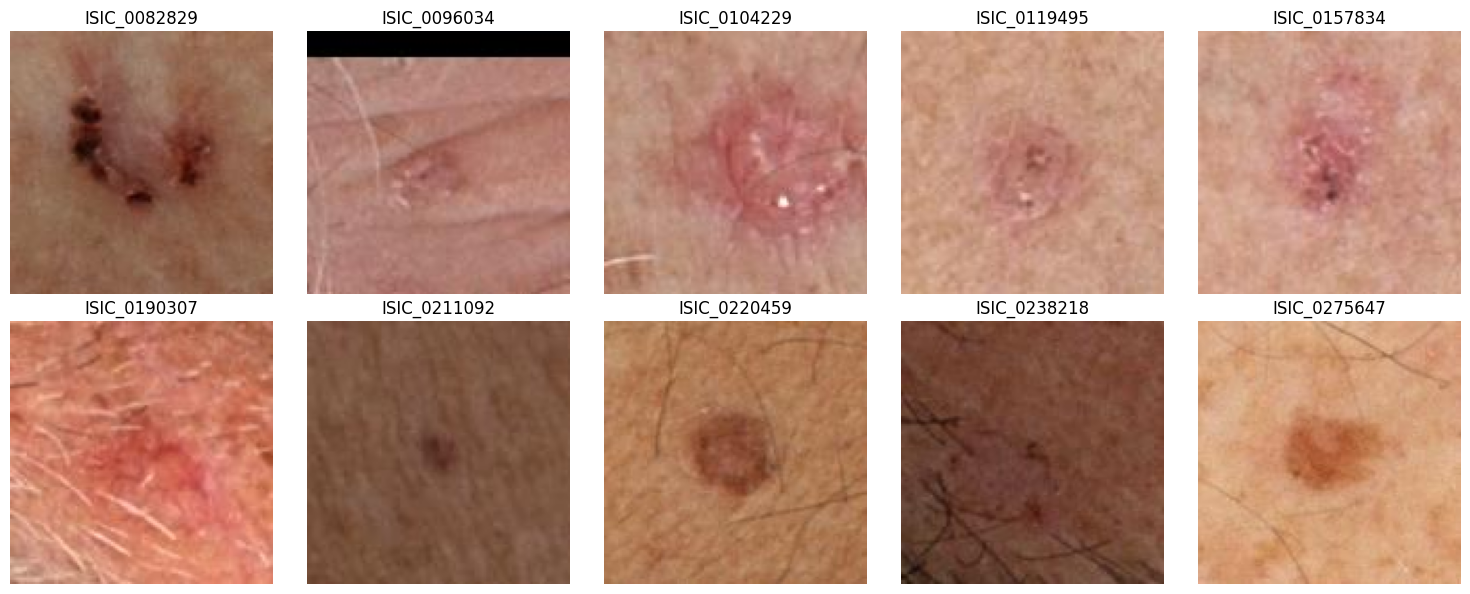

In [26]:
import matplotlib.pyplot as plt

# get first 10 isic_ids as sample and view them 
isic_ids = df_filtered['isic_id'].head(10)

# plot the images
plt.figure(figsize=(15, 6))
for i, isic_id in enumerate(isic_ids):
    image_path = os.path.join(image_dir, f"{isic_id}.jpg")
    img = Image.open(image_path).convert("RGB")
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(isic_id)
    plt.axis('off')

plt.tight_layout()
plt.show()

### 3. Image resize to 128*128 size images

Images are in different image sizes so this different image sizes are made to same size images

ISIC_0082829: (128, 128)
ISIC_0096034: (128, 128)
ISIC_0104229: (128, 128)
ISIC_0119495: (128, 128)
ISIC_0157834: (128, 128)
ISIC_0190307: (128, 128)
ISIC_0211092: (128, 128)
ISIC_0220459: (128, 128)
ISIC_0238218: (128, 128)
ISIC_0275647: (128, 128)


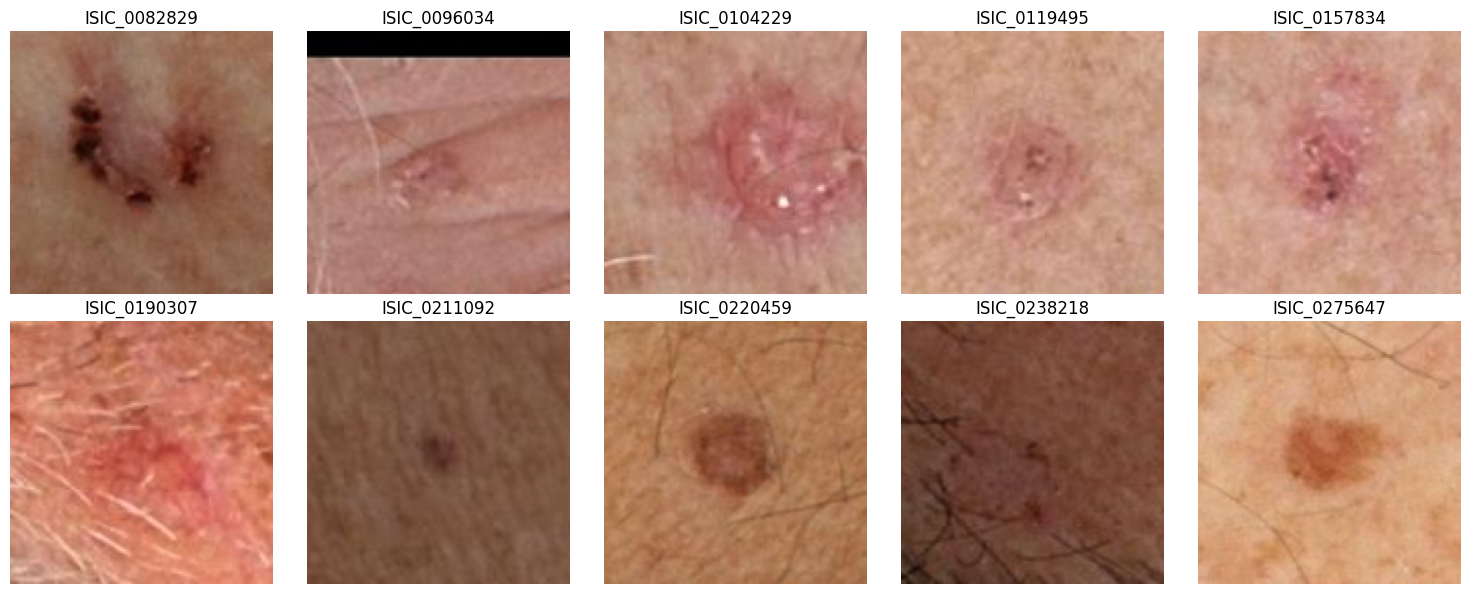

In [27]:
import os
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'
save_dir = '/kaggle/working/resized_images'
os.makedirs(save_dir, exist_ok=True)

# get sample 10 images to test
isic_ids = df_filtered['isic_id'].head(10)

# plot resized images
plt.figure(figsize=(15, 6))
for i, isic_id in enumerate(isic_ids):
    image_path = os.path.join(image_dir, f"{isic_id}.jpg")
    img = Image.open(image_path).convert("RGB")

    # fit image to 128x128
    img_resized = ImageOps.fit(img, (128, 128), method=Image.BICUBIC)

    # show the size of the image
    print(f"{isic_id}: {img_resized.size}")
    
    # save resized image
    save_path = os.path.join(save_dir, f"{isic_id}.jpg")
    img_resized.save(save_path)
    
    # show image in plot 
    plt.subplot(2, 5, i + 1)
    plt.imshow(img_resized)
    plt.title(isic_id)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [28]:
# check for specific classes 
# there are classes in the malignant data so we get the distinct cases 
unique_classes = df_filtered['iddx_3'].unique()
print("Distinct classes in 'iddx_3':", unique_classes)
print("Distinct classes", len(unique_classes))

# count occurrences of each class
class_counts = df_filtered['iddx_3'].value_counts()
print("Class counts in 'iddx_3':\n", class_counts)

Distinct classes in 'iddx_3': ['Squamous cell carcinoma in situ' 'Basal cell carcinoma'
 'Squamous cell carcinoma, Invasive' 'Melanoma in situ'
 'Melanoma Invasive' 'Melanoma, NOS' 'Melanoma metastasis'
 'Squamous cell carcinoma, NOS']
Distinct classes 8
Class counts in 'iddx_3':
 iddx_3
Basal cell carcinoma                 163
Melanoma in situ                      80
Melanoma Invasive                     63
Squamous cell carcinoma in situ       49
Squamous cell carcinoma, Invasive     22
Melanoma, NOS                         13
Squamous cell carcinoma, NOS           2
Melanoma metastasis                    1
Name: count, dtype: int64


### 4. Sample generation code from the k-nearest 

generate samples from the data 
1. get random sample from the data (base points from the dataset)
2. for each data point, randomly choose one of its k neighbors (excluding itself)
3. get the real vector for each base points and the neighbours
4. generate new points by interpolating between each base and its chosen neighbor.

There are 8 different malignant() cases for that we need to generate seperate generation for each different cases.

In [9]:
# sample data of x
X = np.random.randn(10,6)
X.shape

(10, 6)

In [10]:
# X data size is the (number_of_dataset, n_vector_space)
# n_to_sample number of samples to generate
# cl means number of class the index of the class
def G_SM1(X, y,n_to_sample,cl):
    
    # if the incoming x data is more than 5 samples
    if (X.shape[0] > 5):
        n_neigh = 5 + 1
    else:
        # if not get the neighbors as available points
        n_neigh = X.shape[0]
        
    # initialize the model with the NearestNeighbors
    nn = NearestNeighbors(n_neighbors=n_neigh, n_jobs=1)
    nn.fit(X)
    
    # Returns indices of neighbors of each point
    # ind means the nearest neighbours to each point in
    dist, ind = nn.kneighbors(X)
    ##########
    # ind is the indexes of nearest neighbors that are close to the current index
    ##########
    
    # generating samples
    # get random index list from the data
    # base_indices that are get for generating new samples
    base_indices = np.random.choice(list(range(len(X))),n_to_sample)

    # considered neighbors that are most nearest neighbours
    neighbor_indices = np.random.choice(list(range(1, n_neigh)),n_to_sample)

    # get the correct data from the x    
    X_base = X[base_indices]
    X_neighbor = X[ind[base_indices, neighbor_indices]]

    # calculate samples based on the random value 
    # interpolate the vectors
    samples = X_base + np.multiply(np.random.rand(n_to_sample,1),
            X_neighbor - X_base)

    # return the vectors size: (n_to_sample x n_vector_space)
    # and there corresponding labels size: (n_to_sample)
    # return class and the label
    return samples, [cl]*n_to_sample

In [11]:
interpolated_sample, y = G_SM1(X, 1, 5, 0)
# X size is (10 x 6)
# we made the interpolation with the nearest points
# made the sample of 5 generated
# so size become (5 x 6)
print(interpolated_sample)

[[ 0.17956775  0.13188039  0.92535135  0.19018899  0.43102035 -0.60570872]
 [ 0.45940618 -0.20849299  1.01431345  0.89220495  0.43399796  0.59205164]
 [ 0.11827755 -0.12207937  0.93733927  0.15600179 -0.6318924  -0.073869  ]
 [-0.24081801  0.52739265 -0.89115608 -1.12691408  0.36491216 -0.12089636]
 [ 1.06684736 -0.92371071  0.10354257 -0.5771348   0.24115727 -0.4717744 ]]


### 5. Make training dataset CSV

we make the training dataset with all the negative cases and the 10000 of positive cases.

In [12]:
# filter malignant (target == 1)
df_positive = df[df["target"] == 1]

# filter benign (target == 0), randomly sample 10,000 rows
df_negative = df[df["target"] == 0].sample(n=10000, random_state=42)

# combine both positive and negative cases
df_balanced = pd.concat([df_positive, df_negative]).reset_index(drop=True)

# shuffle the data
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# save to a new CSV
df_balanced.to_csv("/kaggle/working/train_created.csv", index=False)

In [13]:
df_balanced.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0926252,0,IP_9587089,50.0,female,lower extremity,6.76,TBP tile: close-up,3D: XP,20.164940,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.954910
1,ISIC_8686405,0,IP_5799983,70.0,male,anterior torso,2.62,TBP tile: close-up,3D: white,19.214970,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.628460
2,ISIC_8225982,0,IP_1759413,40.0,male,posterior torso,4.41,TBP tile: close-up,3D: XP,22.939674,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999964
3,ISIC_7651436,0,IP_1394710,55.0,male,posterior torso,5.60,TBP tile: close-up,3D: XP,26.304145,...,IL_9215914,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999964
4,ISIC_0991062,0,IP_5714646,40.0,male,anterior torso,3.42,TBP tile: close-up,3D: XP,13.659380,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.975210


### 5.1 Make a tranformation and see the data (64x64)

Tranformation to 64 by 64 reduce the computational cost 

ISIC_0082829: (64, 64)
ISIC_0096034: (64, 64)
ISIC_0104229: (64, 64)
ISIC_0119495: (64, 64)
ISIC_0157834: (64, 64)
ISIC_0190307: (64, 64)
ISIC_0211092: (64, 64)
ISIC_0220459: (64, 64)
ISIC_0238218: (64, 64)
ISIC_0275647: (64, 64)


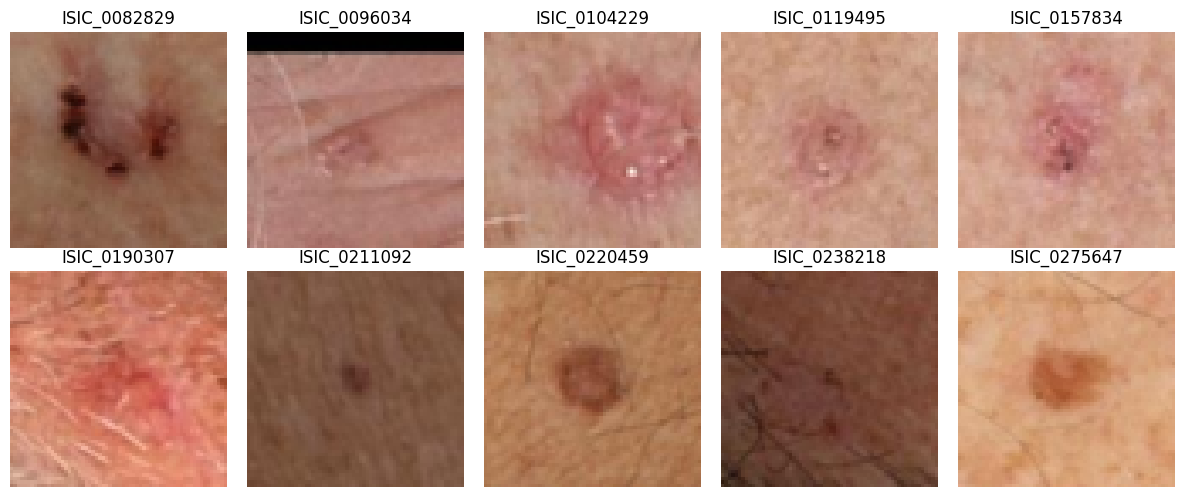

In [14]:
# transformation
resize_transform = transforms.Resize((64, 64))
# image dir
image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'

# get sample 10 images to test
isic_ids = df_filtered['isic_id'].head(10)

# plot resized images
plt.figure(figsize=(12, 5))
for i, isic_id in enumerate(isic_ids):
    image_path = os.path.join(image_dir, f"{isic_id}.jpg")
    img = Image.open(image_path).convert("RGB")

    # apply resize transform
    img_resized = resize_transform(img)
    print(f"{isic_id}: {img_resized.size}")

    # show image in plot 
    plt.subplot(2, 5, i + 1)
    plt.imshow(img_resized)
    plt.title(isic_id)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
# transform the image size to the 64x64 resolution 
image_size = 64
transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

### 6. Make the dataloader and get the dataset

First we get the data that are malignant.

Apply some transformation to lager the dataset.

Make the dataset.

In [16]:
# data paths that contain images and other 
csv_path = '/kaggle/working/train_created.csv'
image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'

# read the csv as data frame
df = pd.read_csv(csv_path)

# custom dataset class 
# this implement how one training data is get from the dataset
# if transformation is needed need to pass the transformation to transform
class ISICDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_dir, f"{row['isic_id']}.jpg")
        image = Image.open(image_path).convert("RGB")
        
        # resize and center crop using ImageOps.fit
        image = ImageOps.fit(image, (128, 128), method=Image.BICUBIC)

        if self.transform:
            image = self.transform(image)

        label = int(row['target'])
        return image, label

In [ ]:
# number of workers for dataloader
workers = 2

# batch size during training
batch_size = 128

# size using a transformer.
image_size = 64

# number of channels in the training images. For color images this is 3
nc = 3

# size of latent space
n_z = 300

# learning rate 
lr = 0.0002

# epochs 
epochs = 5

Batch Size:  torch.Size([128, 3, 64, 64])


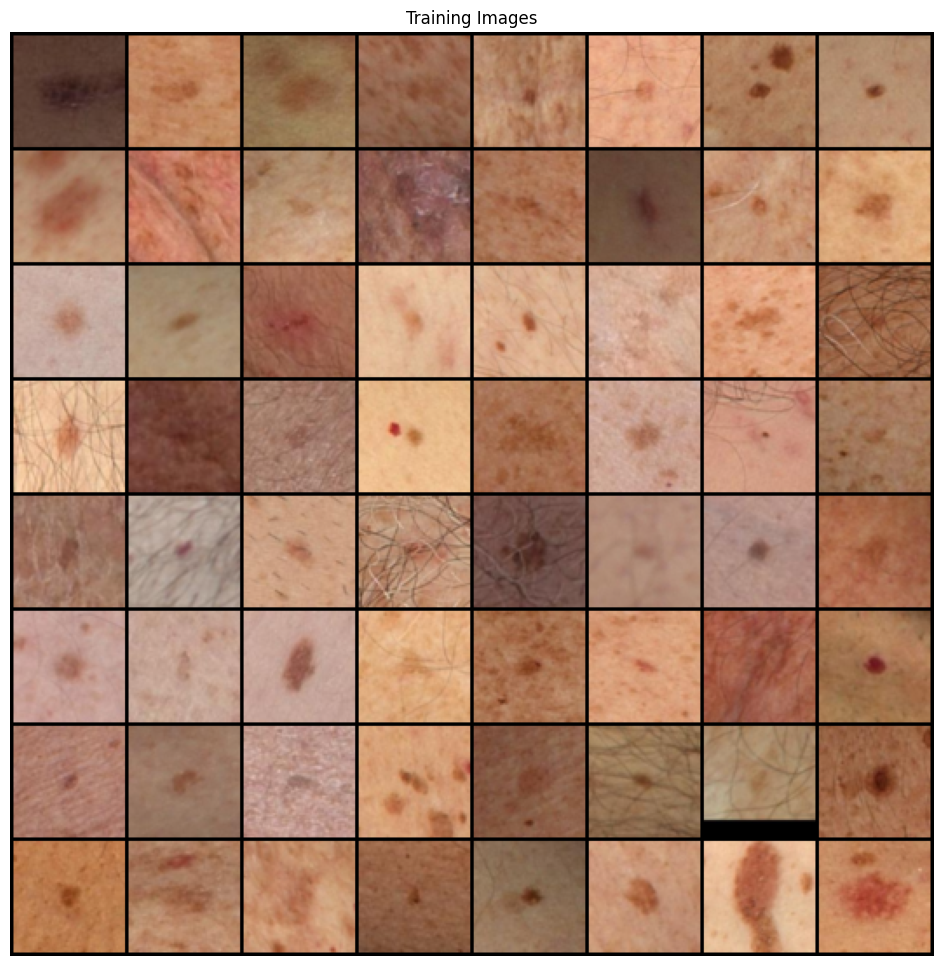

In [18]:
# data paths that contain images and other 
csv_path = '/kaggle/working/train_created.csv'

# read the csv as data frame
df = pd.read_csv(csv_path)
  
# generate sample dataset
train_dataset = ISICDataset(df, image_dir, transform=transform)

# create the dataloader
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# plot some training images
real_batch = next(iter(dataloader))
print("Batch Size: ",real_batch[0].size())
plt.figure(figsize=(12,12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### 7. Make Encoder models 

Encoder Decoder architecture is used to generate new images.

After training the model then it used to interpolate the malignant images and generate new synthetic images.

In [19]:
# create encoder module this is used to encode the image
class Encoder(nn.Module):
    def __init__(self, n_channel, dim_h, n_z):
        super(Encoder, self).__init__()

        # number of input channels
        self.n_channel = n_channel
        # input image size 
        self.dim_h = dim_h
        # latent space size
        self.n_z = n_z
        
        # convolutional filters
        # we use 5 convolution layers as our image is 64x64
        self.conv = nn.Sequential(
            
            # 1 st convolution layer 
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            #nn.ReLU(True),(32 x 32 x 64)
            nn.LeakyReLU(0.2, inplace=True),
            
            # 2 nd convolution layer
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            #nn.ReLU(True),(16 x 16 x 64*2)
            nn.LeakyReLU(0.2, inplace=True),

            # 3 rd convolution layer 
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            #nn.ReLU(True),(8 x 8 x 64*4)
            nn.LeakyReLU(0.2, inplace=True),
            
            
            # 4 th convolution layer
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),
            #nn.ReLU(True),(4 x 4 x 64*8)
            nn.LeakyReLU(0.2, inplace=True),

            # 5 th convolution layer
            nn.Conv2d(self.dim_h * 8, self.dim_h * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.dim_h * 16),
            #nn.ReLU(True),(1 x 1 x 64*16)
            nn.LeakyReLU(0.2, inplace=True)) 

        
        # final layer is fully connected
        self.fc = nn.Linear(self.dim_h * (2 ** 4), self.n_z)
        

    def forward(self, x):
        # print('enc')
        # input size is torch.Size([128, 3, 64, 64])
        
        x = self.conv(x)
        # print(x.size()) # torch.Size([128, 1024, 1, 1])
        
        x = x.squeeze()
        # print('aft squeeze ',x.size()) # torch.Size([128, 1024])
        
        
        x = self.fc(x)
        # print('out ',x.size()) #torch.Size([128, 320])
        
        # out  torch.Size([128, 300])
        return x

In [41]:
# debug cell
sample_encoder = Encoder(nc, image_size, n_z)
# sample forward pass
encoded_output = sample_encoder(real_batch[0])

### 7. Make Decoder models

Decoder decode the latent space vector to generate new image

In [20]:
class Decoder(nn.Module):
    def __init__(self, n_channel, dim_h, n_z):
        super(Decoder, self).__init__()
        
        # number of input channels
        self.n_channel = n_channel
        # input image size 
        self.dim_h = dim_h
        # latent space size
        self.n_z = n_z

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 8 * 8),
            nn.ReLU())

        # 4 deconvolutional filters as encoder has 5 convolution layers
        self.deconv = nn.Sequential(
            # 1 st deconvolution layer 
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4, stride=2, padding=1),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),

            # 2 nd deconvolution layer 
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4, stride=2, padding=1),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),

            # 3 rd deconvolution layer 
            nn.ConvTranspose2d(self.dim_h * 2, self.dim_h, 4, stride=2, padding=1),
            nn.BatchNorm2d(self.dim_h),
            nn.ReLU(True),

            # 4 th deconvolution layer 
            nn.ConvTranspose2d(self.dim_h, 3, 3, stride=1, padding=1),
            #nn.Sigmoid())
            nn.Tanh())

    def forward(self, x):
        #print('dec')
        # print('input ',x.size())
        x = self.fc(x)
        
        # after the latent space make as channels to pass to the deconvolution layers
        x = x.view(-1, self.dim_h * 8, 8, 8)
        
        # deconvolve the layer
        x = self.deconv(x)

        # output the image
        return x

In [43]:
# debug cell
sample_decoder = Decoder(nc, image_size, n_z)
# sample forward pass
decoded_output = sample_decoder(encoded_output)
# print the size of the data
print(decoded_output.size())

torch.Size([128, 3, 64, 64])


### Train the Encoder Decoder model to generate new sample data

Train the encoder decoder model to generate synthetic images.

There are few optimizing strategies to enhance the generated images.

In [29]:
# initialize encoder and decoder
encoder = Encoder(nc, image_size, n_z)
decoder = Decoder(nc, image_size, n_z)

# find available gpus
t0 = time.time()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# add to the encoder and decoder to the device
decoder = decoder.to(device)
encoder = encoder.to(device)

# decoder loss function
criterion = nn.MSELoss()
criterion = criterion.to(device)

# one optimizer with encoder and decoder
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=args.lr)

# add optimizers 
enc_optim = torch.optim.Adam(encoder.parameters(), lr=args.lr)
dec_optim = torch.optim.Adam(decoder.parameters(), lr=args.lr)

cpu


In [31]:
# debug cell
# simple one step in training to check for the dimentions

z_hat = encoder(real_batch[0])
print('zhat ', z_hat.size())       
x_hat = decoder(z_hat) #decoder outputs tanh
print('xhat ', x_hat.size())
mse = criterion(x_hat,real_batch[0])
print('mse ', mse)

zhat  torch.Size([128, 300])
xhat  torch.Size([128, 3, 64, 64])
mse  tensor(0.8954, grad_fn=<MseLossBackward0>)
